In [1]:
# test CNN to classify

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2 
from tensorflow.keras.utils import to_categorical
import time

In [3]:
# class to track execution time of certain code events
class track_time:
    def __init__(self):
        self.events = []
        self.add('Start')
    def add(self, name: str) -> None:
        if name == "total":
            raise error("Cant use the name 'total'.")
        self.events.append([name,time.time()])
    def get_time(self): # calculate time between events and total
        self.timed_events = {}
        for (n, event) in enumerate(self.events):
            elapsed_time = 0
            if n+1 == len(self.events):
                # last element
                elapsed_time = time.time() - event[1]
            else:
                elapsed_time = self.events[n+1][1] - event[1]
            self.timed_events[event[0]] = elapsed_time
        self.timed_events['total'] = time.time() - self.events[0][1]
        return self.timed_events
    def __str__(self):
        output = ""
        if not hasattr(self,'timed_events'):
            self.get_time()
        output += ("  Event tracked  |  Duration  \n")
        output += ("==============================\n")
        for name,duration in self.timed_events.items():
            output += (" "+name+"\t\t\t| "+str(round(duration,3))+"\n")
        return output

In [4]:
# timer
timer = track_time()
timer.add("Read in data")
# load image data s and reshape 
data = pd.read_pickle('images_df_numerical.pkl')
# convert to numpy array
(data_images, data_label) = (data['data'],data['Species'])
classes = data_label.unique()
image_size = data_images[0].size
samples = data_images.size
image_shape = (216,334,3) # height, width , channel
# reshape every row to the image, swap rgbs and scale to 0-1
data_images = [
    cv2.cvtColor(row.reshape(image_shape), cv2.COLOR_BGR2RGB).astype('float32')/255. 
    for row in data_images]
data_label = [row.astype('int32') for row in data_label]

In [25]:
timer.add("Build CNN")
### build cnn
input_image = keras.Input(shape=image_shape)

x = layers.Conv2D(32, (3, 3), activation='relu')(input_image)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(64*2*2*2, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(classes.size)(x)
cnn = keras.Model(input_image,output)

timer.add("Compile CNN")
cnn.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
cnn.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 216, 334, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 214, 332, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 107, 166, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 105, 164, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 52, 82, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 50, 80, 64)        3692

In [ ]:
# train cnn
timer.add("Split Train/Test")
(x_train_images,x_test_images, x_train_label, x_test_label) = train_test_split(data_images,data_label,test_size=0.2) 

x_train_images = np.array(x_train_images)
x_test_images = np.array(x_test_images)
x_train_label = np.array(x_train_label)
x_test_label = np.array(x_test_label)

timer.add("Train CNN")
history = cnn.fit(x_train_images,x_train_label,
                epochs=100,
                batch_size=100,
                shuffle=True,
                validation_data=(x_test_images,x_test_label)
               )

cnn.save('test_cnn.keras')

10/10 - 1s - loss: 1.7776 - accuracy: 0.4104 - 591ms/epoch - 59ms/step
0.4104234576225281


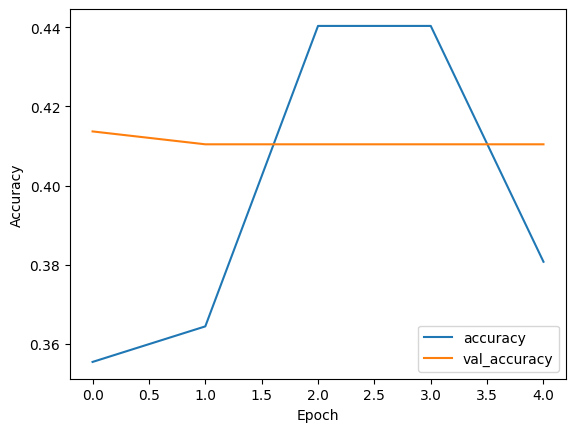

In [28]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.savefig("test_cnn.png")

test_loss, test_acc = cnn.evaluate(x_test_images,  x_test_label, verbose=2)
print(test_acc)

In [ ]:
timer.get_time()
print(timer)